# Homework 3 

In [1]:
from numpy.lib.stride_tricks import as_strided
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2 as cv

# Задача №1 - Лес или пустыня?

Часто при анализе изображений местности необходимо понять ее характер. В частности, если определить, что на изображении преобладет вода, то имеет смысл искать корабли на таком изображении. Если на картинке густой лес, то, возможно, это не лучшая зона для посадки дрона или беспилотника.

Ваша задача - написать программу, которая будет отличать лес от пустыни. В приложении можно найти реальные спутниковые снимки лесов и пустынь.

Примеры изображений:
<table><tr>
    <td> <img src="https://i.ibb.co/nmHHctW/test_image_00.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/dM77C4b/test_image_06.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

**Решение задачи:**

In [2]:
def desert_forest_classifier(image: np.ndarray) -> str:
    """
    Determines what is shown in the picture: desert or forest
    
    :param image: numpy ndarray (M, N, 3) - image in HSV
    :return: label of image: DESERT or FOREST
    
    """
    
    if image.ndim != 3:
        raise RuntimeError('incorrect image format')
    
    desert_label, forest_label = 'DESERT', 'FOREST'
    green_low = np.array([36, 0, 0], dtype=image.dtype)
    green_high = np.array([86, 255, 255], dtype=image.dtype)
    
    new_shape = (image.shape[0] * image.shape[1], image.shape[-1])
    new_strides = image.strides[1:]
    
    image_strided = as_strided(image, shape=new_shape, strides=new_strides)
    
    colors, counts = np.unique(image_strided, return_counts=True, axis=0)
    color_mode = colors[np.argmax(counts)]

    if np.all(green_low <= color_mode) and np.all(color_mode <= green_high):
        return forest_label
    
    return desert_label

**Тестирование решения на примерах:**

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.93it/s]


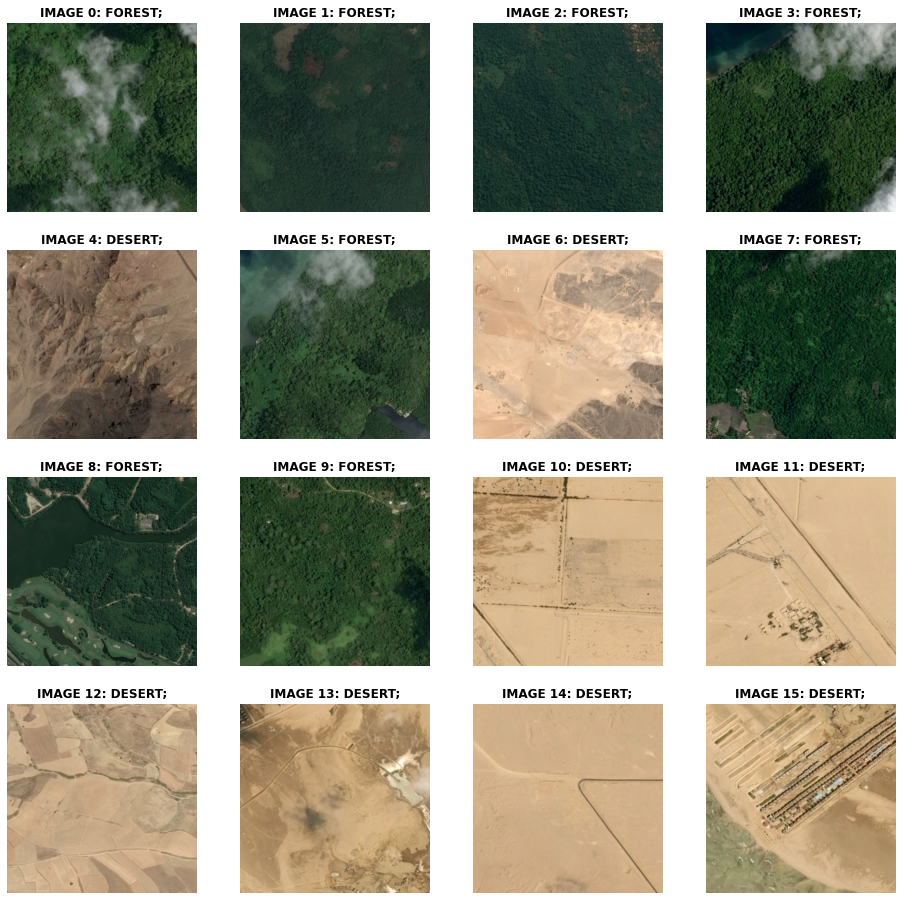

In [3]:
path = './desert_forest/test_image_'

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.ravel()

for i in tqdm(range(axes.size)):
    
    image_path = f'{path}0{i}.jpg' if i < 10 else f'{path}{i}.jpg'
    
    image = cv.imread(image_path)
    image = cv.cvtColor(image, code=cv.COLOR_BGR2HSV)
    
    label = desert_forest_classifier(image)
    
    image = cv.cvtColor(image, code=cv.COLOR_HSV2RGB)
    
    axes[i].set_title(f'IMAGE {i}: {label};', fontweight='bold')
    
    axes[i].imshow(image)
    axes[i].axis('off')
    
plt.show()

# Задача №2 - Раздели объекты в шуме

Дано зашумленное изображение с 3 объектами: круг, треугольник и фон. Треубется выдлеить каждый объект, фон, круг и треугольник в бинарные маски. То есть треубется найти геометрическое место каждого объекта на изображении. Незашумленное изображение приведено __только__ для оценки качества решения. Запрещено использовать любую инофрмацию о незашумленном изображении в решении. 

Придумайте способ численной оценки качества полученного результата.

<table><tr>
    <td> <img src="segmentation/gt.png" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="segmentation/noise.png" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

**Решение задачи:**

In [4]:
def open_blur(src, kernel_morph, kernel_blur, iterations=1):
    """
    Performs opening operation and blur image
    
    :param src: 2-dim numpy ndarray - GrauScale image
    :param kernel_morph: kernel for opening
    :param kernel_blur: kernel for blur
    :param iterations: number of iterations for opening
    
    :return: 2-dim numpy ndarray - corrected image
    
    """
    
    image_corrected = cv.erode(src, kernel_morph, iterations=iterations)
    image_corrected = cv.dilate(image_corrected, kernel_morph, 
                                iterations=iterations)
    image_corrected = cv.GaussianBlur(image_corrected, kernel_blur, 0)
    
    return image_corrected

In [5]:
def perform_segmentation(image):
    """
    Finds background, triangle and circle mask
    
    :param image: 2-dim numpy ndarray - GrayScale image
    
    :return: background mask, triangle mask, circle mask - 
    2-dim numpy ndarrays - GrayScale images
    
    """
    
    ker_back, ker_figs, ker_filter = (5, 5), (21, 21), (35, 35)
    iter_amount = 5
    
    image_blured_back = cv.GaussianBlur(image_noisy, ker_back, 0)
    image_blured_figs = cv.GaussianBlur(image_noisy, ker_figs, 0)
    
    _, back_inv = cv.threshold(image_blured_back, 0, 1, 
                               cv.THRESH_BINARY + cv.THRESH_OTSU)
    
    figures = image_blured_figs * back_inv
    hist, _ = np.histogram(figures, bins=255, range=(1, 255))
    figures[figures == 0] = hist.argmax() + 1
    
    _, figure1 = cv.threshold(figures, 0, 1, 
                              cv.THRESH_BINARY + cv.THRESH_OTSU)
    _, figure2 = cv.threshold(figures, 0, 1, 
                              cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    
    figure2 = figure2 * back_inv
    
    back_inv = open_blur(back_inv, ker_filter, ker_filter, iter_amount)
    figure1 = open_blur(figure1, ker_filter, ker_filter, iter_amount)
    figure2 = open_blur(figure2, ker_filter, (39, 39), iter_amount)
    
    return 1 - back_inv, figure1, figure2

**Тестирование на примере и численная оценка качества:**

In [6]:
image_noisy_path = './segmentation/noise.png'
image_path = './segmentation/gt.png'
image_noisy = cv.imread(image_noisy_path)
image = cv.imread(image_path)
image_noisy = cv.cvtColor(image_noisy, code=cv.COLOR_BGR2GRAY)
image = cv.cvtColor(image, code=cv.COLOR_BGR2GRAY)

In [7]:
image = image[:image_noisy.shape[0], :image_noisy.shape[1]]

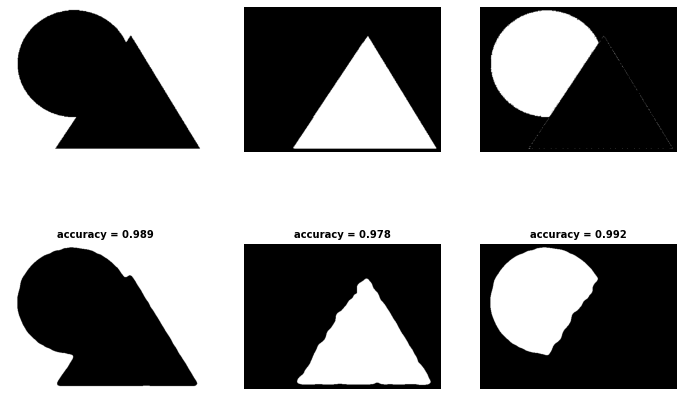

In [8]:
masks = [cv.inRange(image, 0, 120),
         cv.inRange(image, 150, 255),
         cv.inRange(image, 142, 150)]

segments = perform_segmentation(image_noisy)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

for i, mask in enumerate(masks):
    
    accuracy = np.sum(mask / 255 == segments[i])
    accuracy = accuracy / (mask.shape[0] * mask.shape[1])
    
    axes[i + len(masks)].set_title(f'accuracy = {np.round(accuracy, 3)}', 
                                   fontweight='bold', fontsize=10)
    
    axes[i + len(masks)].imshow(segments[i], cmap='gray')
    axes[i].imshow(mask, cmap='gray')
    
    axes[i + len(masks)].axis('off')
    axes[i].axis('off')
    
plt.show()

В качестве численной оценки качества решено было взять метрику `accuracy`. На основании оригинального изображения вычисляются корректные маски объектов: фона, треугольника и круга. После чего, вычисляются маски объектов на зашумленном изображении. Для каждой пары, состоящей из полученной алгоритмом маски и оригинальной маски, подсчитывается число пикселей полученной маски равных пикселям оригинальной маски, отнесённое к общему числу пикселей оригинальной маски. 

# Задача №3 - Найди клетки

Даны снимки раковых клеток. Существует задача - определить стадию рака клетки по такому изображению. Для того, чтобы подойти к решению классификации рака клетки, необходимо сначала подготовить данные.

Исходные изображения в реальных задачах могут быть очень большого размера (более 20000 px). Однако из визуального анализа можно заметить, что большая часть этих снимков пустая и не несет в себе полезную информацию.

Ваша задача выделить небольшие ячейки изображений из исходного так, чтобы на ячейках было только изображение клетки.

Пример исходного изображения и нарезанных ячеек клетки.
<img src="../img/cell_example.png" alt="Drawing" style="width: 500px;"/>

В качестве аргументов у функции будут значения:
1. исходное изображние;
2. размер ячейки;
3. количество ячеек.

__Доп вопрос__ - как можно выяснить какие нужны значения аргументов, чтобы они подходили для большинства исходных снимков?

**Класс для решения поставленной задачи:**

In [9]:
class CellImageTransformer:
    """
    Class for cell image compression
    It detects the most informative parts of the image
    and creates new compressed image from them
    
    """
    
    def __init__(self):
        
        self.__reset()
        
    def __reset(self):
        
        self.__cells_weighted = None
        self.__image_cutted = None
        self.__cell_amount = None
        self.__cell_size = None
        self.__image = None
        self.__x = None
        self.__y = None
        
    def __check_args(self):
        
        shape = self.__image.shape[:2]
        
        if self.__cell_size >= shape[0] or self.__cell_size >= shape[1]:
            raise RuntimeError('cell_size is bigger than every image shape;')
        
        cell_amount_general = shape[0] // self.__cell_size
        cell_amount_general *= (shape[1] // self.__cell_size)
        
        if cell_amount_general < self.__cell_amount:
            raise RuntimeError('cell_amount is bigger than general cell amount;')
            
    def __set_image(self, image):
        
        expand_h = image.shape[1] % self.__cell_size
        expand_v = image.shape[0] % self.__cell_size
        
        shape_h = (image.shape[0], expand_h, 3)
        shape_v = (expand_v, image.shape[1] + expand_h, 3)
        
        pad_h = np.ones(shape_h, dtype=np.uint8) * 255
        pad_v = np.ones(shape_v, dtype=np.uint8) * 255
        
        image_expanded = np.hstack((image, pad_h))
        image_expanded = np.vstack((image_expanded, pad_v))
        
        self.__image = image_expanded
    
    def __get_best_image_shape(self):
    
        heigth, width = 1, self.__cell_amount
        limit = int(np.ceil(self.__cell_amount ** 0.5) + 1) 

        for i in range(2, limit):

            if self.__cell_amount % i == 0:
                width, heigth = i, self.__cell_amount // i

        return heigth, width
    
    def __calculate_weighted_cells(self):
        
        image_gray = cv.cvtColor(self.__image, code=cv.COLOR_RGB2GRAY)
        
        heigth = image_gray.shape[0] // self.__cell_size
        width = image_gray.shape[1] // self.__cell_size
        
        cell_size = self.__cell_size
        
        cells_weighted = np.zeros((heigth, width), dtype=np.uint8)
        
        for i in range(heigth):
            for j in range(width):

                i_start, i_end = i * cell_size, (i + 1) * cell_size
                j_start, j_end = j * cell_size, (j + 1) * cell_size

                cell_current = image_gray[i_start: i_end, j_start: j_end].ravel()
                cells_weighted[i, j] = np.sum(cell_current) // cell_current.size
                
        self.__cells_weighted = cells_weighted
    
    def __calculate_cutted_image(self):
        
        image_cutted, cell_size = None, self.__cell_size

        indices = np.argsort(self.__cells_weighted, axis=None)
        y, x = np.unravel_index(indices, self.__cells_weighted.shape)
        
        heigth, width = self.__get_best_image_shape()
        
        for k in range(heigth):
            
            row = None
            
            for l in range(width):
                
                ind = k * width + l

                i_start, i_end = y[ind] * cell_size, (y[ind] + 1) * cell_size
                j_start, j_end = x[ind] * cell_size, (x[ind] + 1) * cell_size

                cell = self.__image[i_start: i_end, j_start: j_end, :]
                row = cell if row is None else np.hstack((row, cell))

            image_cutted = row if image_cutted is None else np.vstack((image_cutted, row))
            
        self.__image_cutted = image_cutted
        self.__x, self.__y = x, y
        
    def transform(self, image, cell_amount, cell_size):
        """
        Detects the most informative parts of the image
        
        To do this staff original image is splited into cells
        One cell is a square which contains cell_size x cell_size pxls
        Then the algorithm selects cell_amount of most informative cells
        and creates new image from them
        
        :param image: 3-dim numpy ndarray (N, M, 3) - RGB image  
        :param cell_amount: int reqiered amount of cells
        :param cell_size: int size of cell
        
        :return: 3-dim numpy ndarray - transformed RGB image 
        
        """
        
        self.__reset()
        
        self.__cell_amount = cell_amount
        self.__cell_size = cell_size
        self.__set_image(image)
        
        self.__check_args()
        self.__calculate_weighted_cells()
        self.__calculate_cutted_image()
        
        return self.__image_cutted
    
    def draw_cutted_cells(self, ax):
        """
        Draws original image and cells from which
        transformed image was created
        
        :param ax: matplotlib.pyplot.axes
        
        """
        
        if self.__image is None:
            return
        
        ax.imshow(self.__image)

        for i in range(self.__cell_amount):

            x = self.__x[i] * self.__cell_size
            y = self.__y[i] * self.__cell_size

            rect = Rectangle((x, y), self.__cell_size, self.__cell_size, linewidth=1, 
                              edgecolor='k', facecolor='none')

            ax.add_patch(rect)
            
        ax.axis('off')

**Тестирование решения:**

In [10]:
cell_amount, cell_size = 49, 150
path = './cells/train'

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.33it/s]


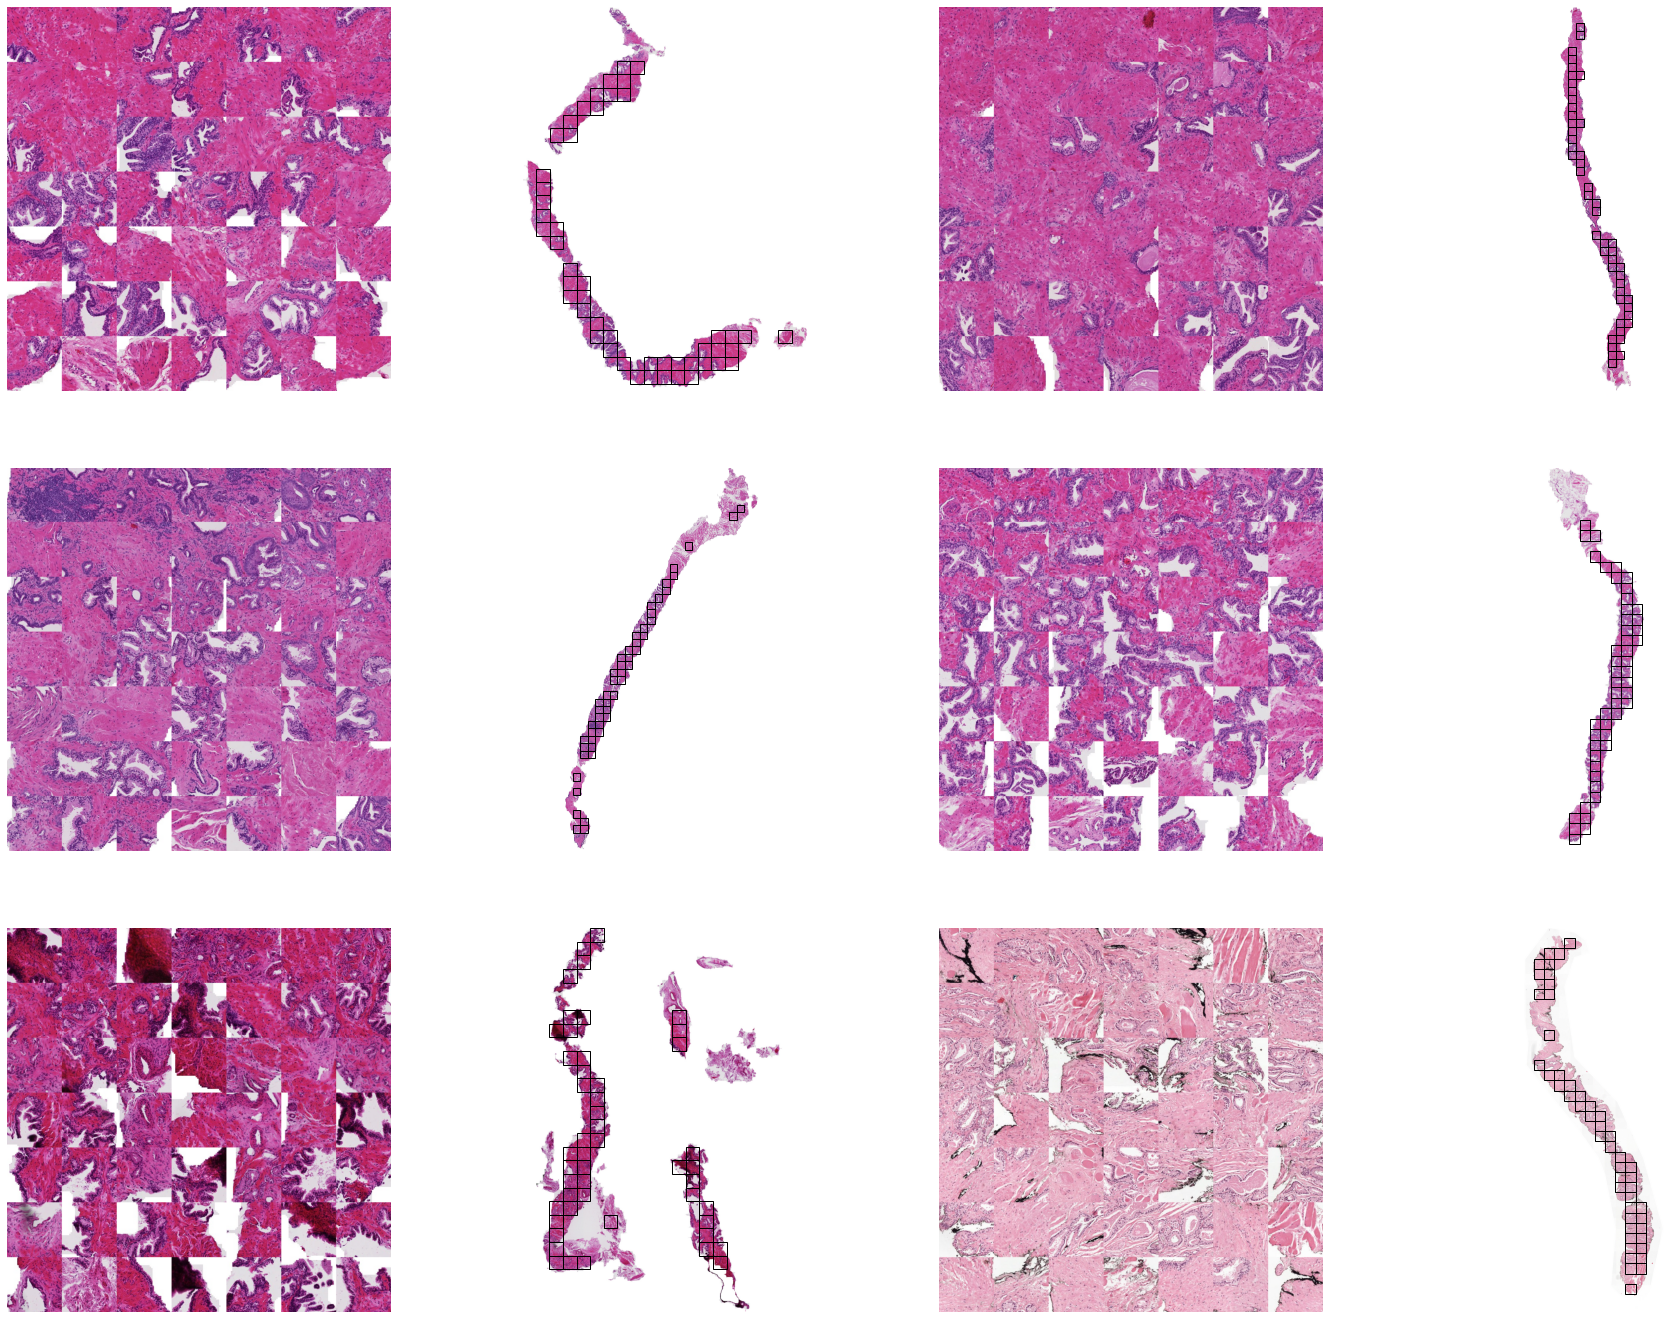

In [11]:
fig, axes = plt.subplots(3, 4, figsize=(32, 24))
axes = axes.ravel()

transformer = CellImageTransformer()

for i in tqdm(range(axes.size // 2)):
    
    image_path = f'{path}{i}_1.jpeg'
    image = cv.imread(image_path) 
    image = cv.cvtColor(image, code=cv.COLOR_BGR2RGB)
    
    image_cutted = transformer.transform(image, cell_amount, cell_size)
    
    axes[2 * i].imshow(image_cutted)
    axes[2 * i].axis('off')
    
    transformer.draw_cutted_cells(axes[2 * i + 1])
    
plt.show()